In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from imblearn.over_sampling import RandomOverSampler

# Import the Dataset
The dataset is the collection of over 150,000 online comments which is labelled by human based on its harmful. There are 5 labels including toxic, severe_toxic, obscene, threat, insult and identity_hate. The data contains offensive and hateful language; however, it is a good fit to AI learning and hateful speech detection. As TikTok is an interactive platform, the dataset does wonder for developing an AI model that prevents negative comments and improving the safety when online.


The data source [link](https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge/data)


In [ ]:
path = "drive/MyDrive/dataset/train.csv"

df = pd.read_csv(path, sep=",")
df = df.drop(columns=["id"])

df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


After importing the dataset to the dataframe using pandas, the text is cleaned by removing unnecessary substring unrelated to the semantic meaning of the sentence.


*   Removing internal URL: Checkout this link https://abc.com -> Check out this link
*   Removing non-alphabetic characters: Hey man, I'm really not trying to edit war. -> Hey man Im really not trying to edit war
*   Removing newline: Explanation\nWhy the edits -> Explanation Why the edits
*   Lowercase and strip the sentence


In [ ]:
def clean_text(text):
  text = re.sub(r'http\S+', '', text)     # remove URL
  text = re.sub(r'[^a-zA-Z\s]', '', text) # remove non-alphabetic chars
  text = re.sub('\s+', ' ', text)         # remove new line and space (\n, \t)
  text = text.lower().strip()
  return text

# Test cases
assert clean_text("Checkout this link https://abc.com") == "checkout this link"
assert clean_text("Hey man, I'm really not trying to edit war.") == "hey man im really not trying to edit war"
assert clean_text("Explanation\nWhy the edits") == "explanation why the edits"
assert clean_text("  Hello   World!  ") == "hello world"
assert clean_text("Hey, check this out: https://example.com. Explanation\nWhy the edits!") == "hey check this out explanation why the edits"


df["comment_text"] = df["comment_text"].apply(clean_text)

df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why the edits made under my userna...,0,0,0,0,0,0
1,daww he matches this background colour im seem...,0,0,0,0,0,0
2,hey man im really not trying to edit war its j...,0,0,0,0,0,0
3,more i cant make any real suggestions on impro...,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [ ]:
# remove empty text
df = df.drop(df[df.comment_text == ''].index)
df = df.reset_index(drop=True)

len(df[df['comment_text'] == ''])

0

Next, we will have a look at some hateful comments in which it is labeled toxic or threat. Notice that a comment can have multiple toxicities (For example, a comment is either toxic or insult at the same time).

**Be aware with vulgar language*

In [ ]:
df[df.toxic > 0].head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,cocksucker before you piss around on my work,1,1,1,0,1,0
12,hey what is it talk what is it an exclusive...,1,0,0,0,0,0
16,bye dont look come or think of comming back ...,1,0,0,0,0,0
42,you are gay or antisemmitian archangel white...,1,0,1,0,1,1
43,fuck your filthy mother in the ass dry,1,0,1,0,1,0


In [ ]:
df[df.threat > 0].head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,hi i am back again last warning stop undoing m...,1,0,0,1,0,0
176,i think that your a fagget get a oife and burn...,1,0,1,1,1,1
600,im also a sock puppet of this accountsuprise s...,1,0,0,1,0,0
802,fuck you smith please have me notified when yo...,1,0,1,1,1,0
1017,wouldnt be the first time bitch fuck you ill f...,1,1,1,1,1,1


We add a new column to the dataframe called "hateful" in which defines the comment text is hateful or normal. A comment is normal if all of the labels is 0, is hateful otherwise. The reason we add new binary column is to serve the binary classification model as well as to plot some data insights.

In [ ]:
df["hateful"] = df.apply(
    lambda r: 1 if (r.toxic or r.severe_toxic or
                    r.obscene or r.threat or
                    r.insult or r.identity_hate) else 0, axis=1)

df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,hateful
0,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,daww he matches this background colour im seem...,0,0,0,0,0,0,0
2,hey man im really not trying to edit war its j...,0,0,0,0,0,0,0
3,more i cant make any real suggestions on impro...,0,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0


# Dataset Insights

TBC

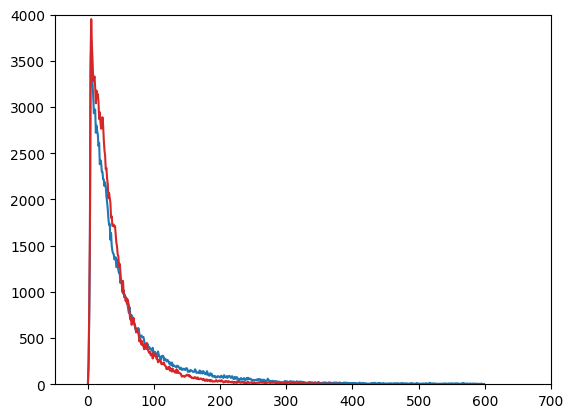

In [ ]:
total = [0] * 1500
unique = [0] * 1500

for text in df['comment_text']:
  text = text.split()
  total[len(text)] += 1
  unique[len(set(text))] += 1

plt.plot(total[:600])
plt.plot(unique[:600], color='tab:red')
plt.xlim(-50, 700)
plt.ylim(0, 4000)
plt.show()

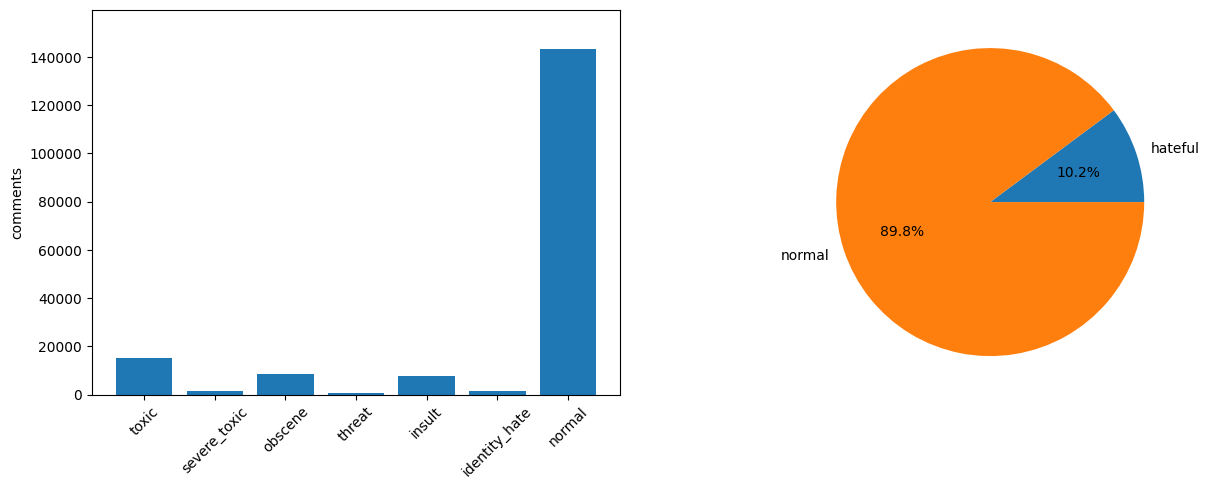

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'normal']
count = [
    len(df[df.toxic > 0]),
    len(df[df.severe_toxic > 0]),
    len(df[df.obscene > 0]),
    len(df[df.threat > 0]),
    len(df[df.insult > 0]),
    len(df[df.identity_hate > 0]),
    len(df[df.hateful == 0])
]

binary_labels = ['hateful', 'normal']
binary_count = [len(df[df.hateful == 1]), len(df[df.hateful == 0])]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(labels, count)
plt.xticks(rotation=45)
plt.ylim(0, len(df))
plt.ylabel('comments')

plt.subplot(1, 2, 2)
plt.pie(binary_count, labels=binary_labels, autopct='%1.1f%%')

plt.show()

In [ ]:
data, target = df[df.columns[:1]].values, df[df.columns[-1]].values

over = RandomOverSampler()
data, target = over.fit_resample(data, target)

sampled_dataset = np.hstack((data, np.reshape(target, (-1, 1))))
transformed_df = pd.DataFrame(sampled_dataset, columns=['comment_text', 'hateful'])
transformed_df = transformed_df.sample(frac=1).reset_index(drop=True)

transformed_df.head()

,comment_text,hateful
0,i dare you block me i will do it again i dare ...,1
1,a bunch of nonacademic clowns are now censorin...,1
2,i wanna fuck you fuck u fuck u fuck u,1
3,no problem uk,0
4,tvtimes images hi ben youve recently uploaded ...,1


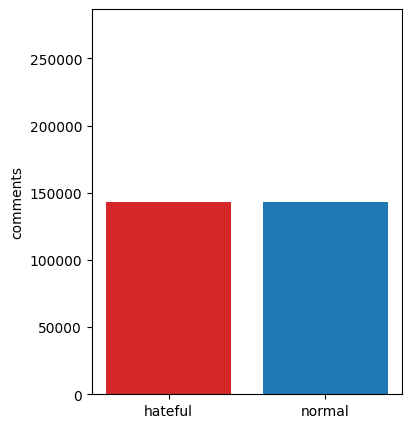

In [ ]:
labels = ['hateful', 'normal']
count = [
    len(transformed_df[transformed_df.hateful == 1]),
    len(transformed_df[transformed_df.hateful == 0])
]

plt.figure(figsize=(4, 5))

plt.bar(labels, count, color=['tab:red', 'tab:blue'])
plt.ylim(0, len(transformed_df))
plt.ylabel('comments')

plt.show()

# Export the data ready for training

After being cleanned, shuffled and resamped, the dataset now is exporting to new file that is ready to feed into a binary classification model.

In [ ]:
transformed_df.to_csv('binary_comment_dataset.csv', encoding='utf-8', index=False)